# **In this notebook, we will be analyzing cats and dogs images using a Transfer Learning Model. I have used 2000 images for  training and 1000 images for tests. An ImageDataGenerator is used to generate images. Without it the model was overfitting the training data.**

### Author: Abhisek Saha
#### Data and idea credit: https://medium.com/analytics-vidhya/transfer-learning-using-inception-v3-for-image-classification-86700411251b

In [ ]:
from zipfile import ZipFile

filename="dogs-vs-cats.zip"

In [ ]:
with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print('Done')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_path= '/content/drive/MyDrive/Colab Notebooks/Data/Cats-Dogs/train'

In [1]:
import keras

In [2]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model

In [4]:
from keras import applications
from keras.preprocessing.image import image
from keras.preprocessing.image import ImageDataGenerator, load_img
import glob
from keras.applications.inception_v3 import InceptionV3

We will be using InceptionV3 model to classify the images. InceptionV3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. 

The model itself is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concatinations, dropouts, and fully connected layers. Batch normalization is used extensively throughout the model and applied to activation inputs. Loss is computed using Softmax.

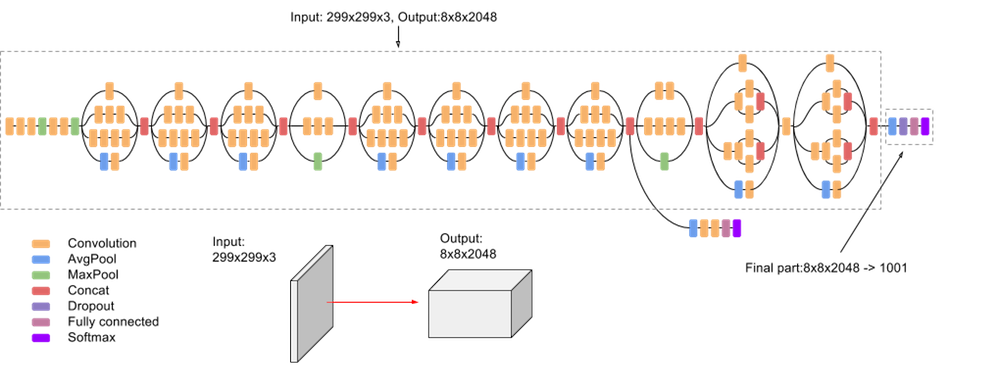

The figure shows a high-level diagram of the model.

We are going to use all the layers in the model except for the last fully connected layer as it is specific to the ImageNet competition.



In [5]:
# Making an instance of the pre-trained model
base_model = InceptionV3(input_shape=(256, 256, 3),
                         include_top=False,
                         weights='imagenet')

In [6]:
# Making all the layers non trainable
for layer in base_model.layers:
  layer.trainable = False

In [7]:
# Creating the output layers to train with our dataset
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
X = Flatten()(base_model.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
X = Dense(units=1024, activation='relu')(X)

# Add a dropout rate of 0.2
X = Dropout(0.2)(X)

# Add a final sigmoid layer for classification
X = Dense(1, activation='sigmoid')(X)

# Final Model
model = Model(base_model.input, X)

# Compile Model
model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Create the respective directories

In [8]:
import os
base_dir ="/content/drive/MyDrive/Colab Notebooks/Data/cats_and_dogs_filtered"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

#Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

#Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

#Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

After rescaling the images, and using Image Augmentation, we flow them in batches of 20 using train_datagen and test_datagen.

## Preprocess Data using ImageDataGenerator

In [9]:
# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   shear_range=0.2)

# The validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(256,256),
                                               batch_size=20,
                                               class_mode='binary')

# Flow validation images in batches of 20 using train_datagen generator
validation_data = test_datagen.flow_from_directory(validation_dir,
                                               target_size=(256,256),
                                               batch_size=20,
                                               class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# index values
train_data.class_indices

{'cats': 0, 'dogs': 1}

# Visualze the data

In [11]:
# images and labels
t_img, t_label = train_data.next()


In [12]:
t_img.shape

(20, 256, 256, 3)

In [13]:
type(train_data)

keras.preprocessing.image.DirectoryIterator

In [14]:
# Lets see some of the training images
import matplotlib.pyplot as plt

def plotImages(img_arr, img_label):
  """
  input: image array
  output: plot images
  """

  for idx, img in enumerate(img_arr):
    #by using the enumerate function, we are giving index to each figure array
    if(idx<10):
      plt.figure(figsize=(5,5))
      plt.imshow(img)
      plt.axes=False
      plt.title(img_label[idx])
      plt.show()



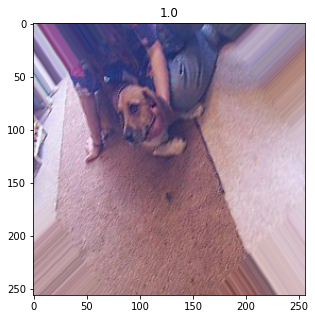

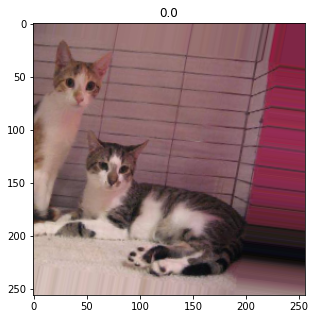

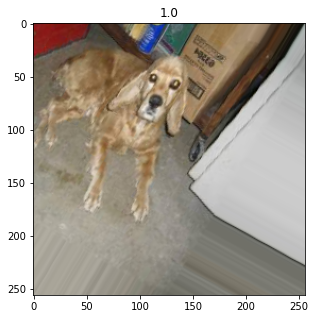

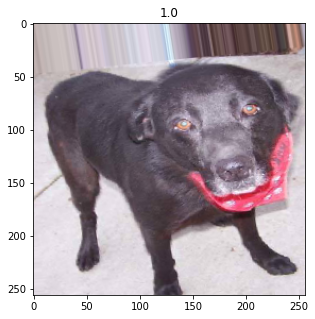

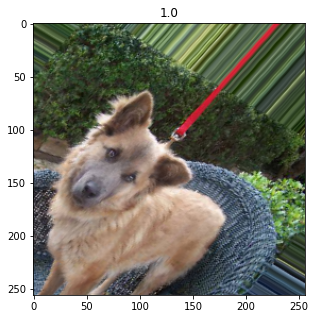

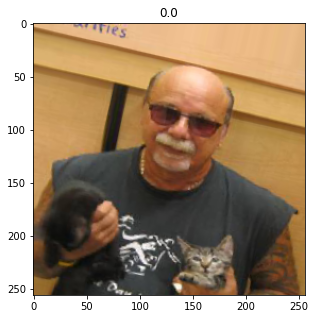

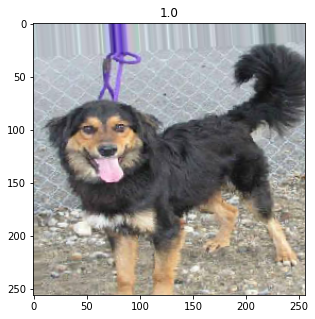

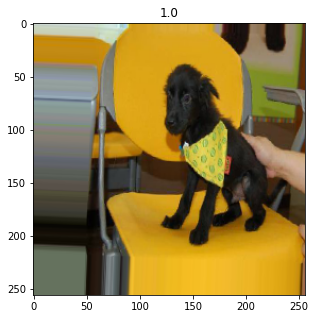

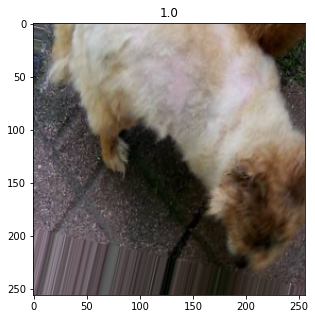

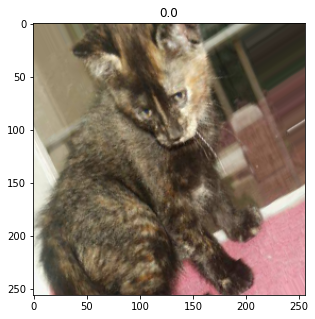

In [15]:
plotImages(t_img, t_label)

## Model CheckPoints

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath="./bestmodel.h5",
                     monitor='accuracy',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor='accuracy',
                   patience=5,
                   verbose=1,
                   min_delta=0.01)

cb = [mc, es]

In [17]:
# Callback function

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [18]:
callbacks = myCallback()
history = model.fit_generator(train_data,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_data,
                              validation_steps=50,
                              verbose=2,
                              callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
100/100 - 528s - loss: 1.1071 - accuracy: 0.9105 - val_loss: 0.1189 - val_accuracy: 0.9810 - 528s/epoch - 5s/step
Epoch 2/30
100/100 - 518s - loss: 0.2577 - accuracy: 0.9585 - val_loss: 0.2130 - val_accuracy: 0.9490 - 518s/epoch - 5s/step
Epoch 3/30
100/100 - 519s - loss: 0.2269 - accuracy: 0.9650 - val_loss: 0.0499 - val_accuracy: 0.9840 - 519s/epoch - 5s/step
Epoch 4/30
100/100 - 518s - loss: 0.1703 - accuracy: 0.9695 - val_loss: 0.0839 - val_accuracy: 0.9880 - 518s/epoch - 5s/step
Epoch 5/30
100/100 - 516s - loss: 0.1694 - accuracy: 0.9745 - val_loss: 0.0887 - val_accuracy: 0.9860 - 516s/epoch - 5s/step
Epoch 6/30
100/100 - 513s - loss: 0.1904 - accuracy: 0.9705 - val_loss: 0.0948 - val_accuracy: 0.9880 - 513s/epoch - 5s/step
Epoch 7/30
100/100 - 513s - loss: 0.2022 - accuracy: 0.9660 - val_loss: 0.0532 - val_accuracy: 0.9870 - 513s/epoch - 5s/step
Epoch 8/30
100/100 - 513s - loss: 0.1435 - accuracy: 0.9760 - val_loss: 0.0236 - val_accuracy: 0.9930 - 513s/epoch - 5s/step


In [ ]:
from keras.models import load_model

saved_model = load_model("/content/bestmodel.h5")

In [19]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

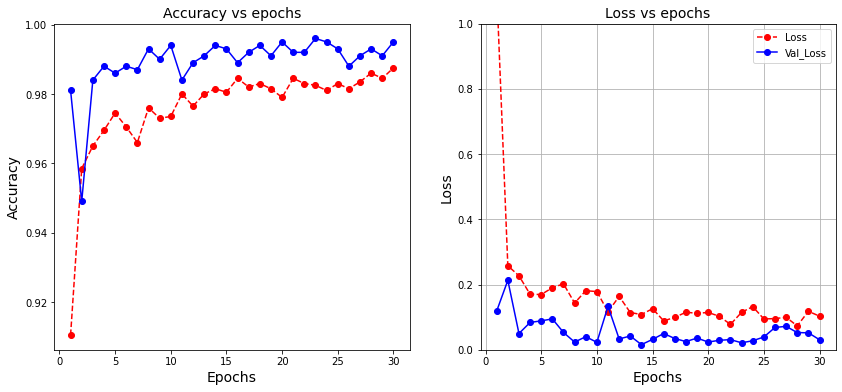

In [24]:
import numpy as np
import matplotlib.pyplot as plt

acc = h['accuracy']
loss = h['loss']
val_acc = h['val_accuracy']
val_loss = h['val_loss']
epochs = np.arange(1,len(acc)+1)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'go--', color='red', label="Accuracy")
plt.plot(epochs, val_acc, 'o-', color="blue", label="Val_Accuracy")
plt.title("Accuracy vs epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=14)

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'go--', color='red', label="Loss")
plt.plot(epochs, val_loss, 'o-', color="blue", label="Val_Loss")
plt.title("Loss vs epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=14)

plt.ylim(0,1)

plt.grid()
plt.legend()
plt.show()

# Test our Model

In [ ]:
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  path = "/content/"+fn
  img = image.load_img(path, target_size=(256,256))
  x = image.img_to_array(img)/255.
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  if(classes[0]>0.5):
    print(fn+ " is a Dog")
  else:
    print(fn+" is is a Cat")

In [28]:
path= "/content/cat.15.jpg"
img = image.load_img(path, target_size=(256,256))

i= image.img_to_array(img)/255.

input_arr = np.array([i])
input_arr.shape 

pred = model.predict(input_arr)

print(pred)

[[1.3877627e-17]]


In [29]:
# Testing with validation cats and dogs images and saving the predictions in lists
path = "/content/drive/MyDrive/Colab Notebooks/Data/cats_and_dogs_filtered/validation/"
cat_path = os.path.join(path, 'cats/')
dog_path = os.path.join(path, 'dogs/')

val_cat_predictions = []
val_dog_predictions = []

for i in range(0,499):
    fn = 'cat.'+str(2000+i)+'.jpg'
    file_name = os.path.join(cat_path,fn)
    img = image.load_img(file_name, target_size=(256,256))
    x = image.img_to_array(img)/255.
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    #print(classes[0])
    if(classes[0]>0.5):
        #print(fn + " is a dog")
        val_cat_predictions.append("dog")
    else:
        #print(fn + " is a cat")
        val_cat_predictions.append("cat")
    
    fn = 'dog.'+str(2000+i)+'.jpg'
    file_name = os.path.join(dog_path,fn)
    img = image.load_img(file_name, target_size=(256,256))
    x = image.img_to_array(img)/255.
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    #print(classes[0])
    if(classes[0]>0.5):
        #print(fn + " is a dog")
        val_dog_predictions.append("dog")
    else:
        #print(fn + " is a cat")
        val_dog_predictions.append("cat")



In [30]:
val_right_cat = val_cat_predictions.count("cat")/500
val_wrong_dog = val_cat_predictions.count("dog")/500

val_right_dog = val_dog_predictions.count("dog")/500
val_wrong_cat = val_dog_predictions.count("cat")/500

percentages = [val_right_cat, val_wrong_dog, val_wrong_cat, val_right_dog]
percentages

[0.99, 0.008, 0.002, 0.996]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


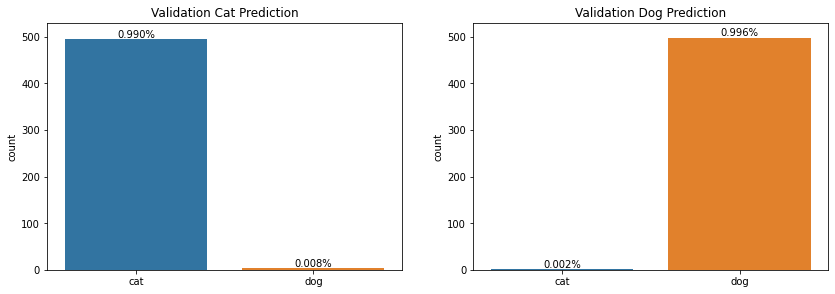

In [35]:
# Plotting the number of times the model gives right and wrong predictions
import seaborn as sns

titles = ["Validation Cat Prediction", "Validation Dog Prediction"]
prediction_data = [val_cat_predictions, val_dog_predictions]
k=0
plt.figure(figsize=(14,10))

for figs in range(1,3):
    plt.subplot(2,2,figs)
    plt.title(titles[figs-1])
    plt.ylim(0,530)
    axis_name = 'ax'+str(figs)
    axis_name = sns.countplot(prediction_data[figs-1], order=['cat','dog'])
    patches = axis_name.patches
    for i in range(len(patches)):
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+4.0
        axis_name.annotate('{:.3f}%'.format(percentages[k]), (x, y), ha='center')
        k+=1



plt.show()

## We get more than 99% accuracy using InceptionV3 model which is much larger than the CNN model accuracy we have obtained before